## Task 4

In [16]:
# Importing pytorch module
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import random

from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

PATH = os.getcwd()

torch.manual_seed(2022)
np.random.seed(2022)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read the data

In [17]:
X_pretrain_csv = pd.read_csv(PATH+'/pretrain_features.csv.zip', compression='zip')
y_pretrain_csv = pd.read_csv(PATH+'/pretrain_labels.csv.zip', compression='zip')
X_train_csv = pd.read_csv(PATH+'/train_features.csv.zip', compression='zip')
y_train_csv = pd.read_csv(PATH+'/train_labels.csv.zip', compression='zip')
X_test_csv = pd.read_csv(PATH+'/test_features.csv.zip', compression='zip')
sample = pd.read_csv(PATH+'/sample.csv')

In [18]:
X_pretrain = np.array(X_pretrain_csv.iloc[:,2:])
y_pretrain = np.array(y_pretrain_csv.iloc[:,1])
X_train = np.array(X_train_csv.iloc[:,2:])
y_train = np.array(y_train_csv.iloc[:,1])
X_test = np.array(X_test_csv.iloc[:,2:])

In [19]:
X_pretrain = torch.from_numpy(X_pretrain).float()
y_pretrain = torch.from_numpy(y_pretrain).float()
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()

### Model

#### Define the model

In [20]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(1000, 1000),
            nn.Hardswish(),
            nn.Linear(1000, 1000),
            nn.Hardswish(),
            nn.Linear(1000, 1000),
            nn.Hardswish(),
            nn.Linear(1000, 1)
        )
  
    def forward(self, x):
        return self.fc(x)

In [21]:
regressor_LUMO = Regressor().to(device)

In [22]:
criterion = nn.MSELoss().to(device)
optim = torch.optim.Adam(regressor_LUMO.parameters(), lr = 1e-5)

In [23]:
# Evaluation function of lumo
def evaluate_LUMO(X_val, y_val, regressor, criterion):
    with torch.no_grad():
        tot_loss = 0

        # If avaiable move data to GPU
        X_val = X_val.float().to(device)

        # Apply the regressor
        predictions = regressor_LUMO(X_val)

        # Calculating the total loss
        loss = criterion(predictions, y_val.unsqueeze(1))

        return loss

#### Train the model with the pretrain data

100%|██████████| 5/5 [04:26<00:00, 53.31s/it]

Total train loss: 0.0274


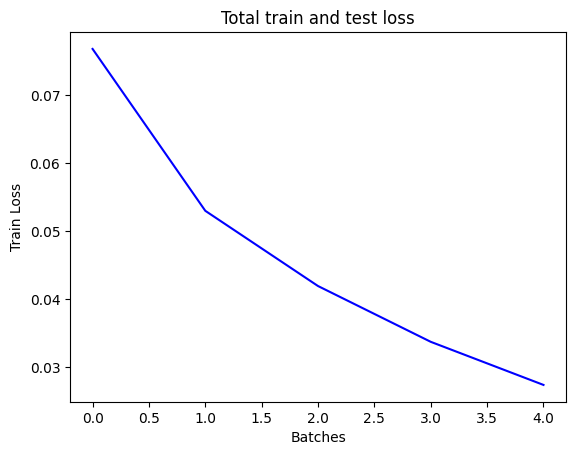

In [24]:
tot_epochs = 5
checkpoint = 5
used_data = 1
batch_size = 64
tot_used_data = int(X_pretrain.shape[0]*used_data)
train_losses = []
test_losses = []

X_pre = X_pretrain.to(device)
y_pre = y_pretrain.to(device)


pretrain_loader = DataLoader(torch.cat((X_pre.to('cpu'), y_pre.unsqueeze(1).to('cpu')), dim=1), batch_size=batch_size, shuffle=True, num_workers=2)

for epoch in tqdm(range(tot_epochs)):
    for batch in pretrain_loader:
        # if avaiable move data to GPU
        batch = batch.to(device)

        X = batch[:, :1000]
        y = batch[:, 1000]

        # zero grad
        optim.zero_grad()

        # Apply Autoencoder
        predictions = regressor_LUMO(X)

        # Calculating the loss
        l2_lambda = 1e-5
        l2_norm = sum(param.pow(2.0).sum() for param in regressor_LUMO.parameters())
        train_loss = criterion(predictions, y.unsqueeze(1)) + l2_lambda * l2_norm

        # backward pass and gradient step
        train_loss.backward()
        optim.step()

    # Save losses
    if used_data < 1:
        test_loss = evaluate_LUMO(X_val, y_val, regressor_LUMO, criterion)
        test_losses.append(test_loss.item())

    train_loss = evaluate_LUMO(X_pre, y_pre, regressor_LUMO, criterion)
    train_losses.append(train_loss.item())

    # Print losses
    if (epoch+1) % checkpoint == 0:
        if used_data < 1:
            print(f'Total train loss: {train_loss:.4f}  |  Total test loss: {test_loss:.4f}')
        else:
            print(f'Total train loss: {train_loss:.4f}')

# Plot the losses
plt.plot(np.asarray(train_losses), 'b')
if used_data < 1:
    plt.plot(np.asarray(test_losses), 'r')
plt.title('Total train and test loss')
plt.xlabel('Batches')
plt.ylabel('Train Loss')
plt.show()

In [25]:

torch.save(regressor_LUMO.state_dict(), PATH+f'/Regressor_LUMO.pt')


#### Train the model with the train data

#### NN training

In [26]:
regressor_HOMO = Regressor().to(device)
regressor_HOMO.load_state_dict(torch.load(PATH+f'/Regressor_LUMO.pt'))

<All keys matched successfully>

In [27]:
criterion = nn.MSELoss().to(device)
optim = torch.optim.Adam(regressor_HOMO.parameters(), lr = 1e-5)

In [28]:
parameters_to_freeze = 4

for index, (name, param) in enumerate(regressor_HOMO.named_parameters()):
    if index < parameters_to_freeze:
        param.requires_grad = False
        print(f'parameter: {name} freezed')
    else:
        param.requires_grad = True
        print(f'parameter: {name} not freezed')

parameter: fc.0.weight freezed
parameter: fc.0.bias freezed
parameter: fc.2.weight freezed
parameter: fc.2.bias freezed
parameter: fc.4.weight not freezed
parameter: fc.4.bias not freezed
parameter: fc.6.weight not freezed
parameter: fc.6.bias not freezed


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([2.0529, 1.3255, 1.8373, 1.3886, 0.9919, 1.1818, 1.4699, 1.7805, 2.9597,
        2.2250, 1.6091, 2.1699, 2.6299, 2.0821, 1.6512, 2.2588, 1.8219, 1.9153,
        2.0805, 1.8471, 1.7162, 1.4922, 1.8839, 1.7666, 1.5809, 1.9557, 2.0912,
        1.6358, 1.8884, 2.3097, 2.1712, 2.0965, 1.4248, 1.8971, 2.5361, 2.2678,
        2.0676, 1.3719, 2.1604, 1.6079, 2.3358, 1.9477, 1.9464, 2.3562, 1.7851,
        1.9792, 1.4437, 2.1981, 1.5414, 1.7152, 2.3681, 1.2625, 1.9664, 2.5484,
        2.0536, 1.9963, 1.5273, 2.0737, 1.5100, 1.7730, 2.0223, 1.8895, 1.3923,
        2.2522, 1.6091, 1.6297, 2.2028, 1.9024, 2.5216, 1.1065, 1.7313, 1.5737,
        1.7108, 1.6888, 1.5466, 1.9012, 2.2206, 2.1132, 1.6139, 2.0552, 1.4888,
        1.4168, 1.4136, 2.

  5%|▌         | 502/10000 [00:32<10:15, 15.44it/s]

Total train loss: 0.2928


 10%|█         | 1002/10000 [01:05<13:13, 11.33it/s]

Total train loss: 0.2651


 15%|█▌        | 1502/10000 [01:40<08:41, 16.29it/s]

Total train loss: 0.2282


 20%|██        | 2002/10000 [02:18<10:18, 12.93it/s]

Total train loss: 0.1845


 25%|██▌       | 2503/10000 [02:43<05:23, 23.21it/s]

Total train loss: 0.1384


 30%|███       | 3002/10000 [03:10<07:40, 15.20it/s]

Total train loss: 0.0994


 35%|███▌      | 3502/10000 [03:43<07:24, 14.63it/s]

Total train loss: 0.0790


 40%|████      | 4002/10000 [04:18<07:16, 13.75it/s]

Total train loss: 0.0724


 45%|████▌     | 4502/10000 [04:54<06:29, 14.12it/s]

Total train loss: 0.0685


 50%|█████     | 5001/10000 [05:31<05:32, 15.05it/s]

Total train loss: 0.0641


 55%|█████▌    | 5501/10000 [06:09<05:35, 13.39it/s]

Total train loss: 0.0591


 60%|██████    | 6005/10000 [06:32<02:44, 24.26it/s]

Total train loss: 0.0529


 65%|██████▌   | 6503/10000 [06:54<02:19, 25.01it/s]

Total train loss: 0.0459


 70%|███████   | 7004/10000 [07:14<01:59, 25.09it/s]

Total train loss: 0.0383


 75%|███████▌  | 7505/10000 [07:35<01:37, 25.60it/s]

Total train loss: 0.0309


 80%|████████  | 8003/10000 [07:55<01:19, 25.19it/s]

Total train loss: 0.0252


 85%|████████▌ | 8503/10000 [08:20<01:08, 21.91it/s]

Total train loss: 0.0209


 90%|█████████ | 9002/10000 [08:44<00:44, 22.28it/s]

Total train loss: 0.0179


 95%|█████████▌| 9501/10000 [09:11<00:32, 15.25it/s]

Total train loss: 0.0157


100%|██████████| 10000/10000 [09:33<00:00, 17.42it/s]


Total train loss: 0.0141


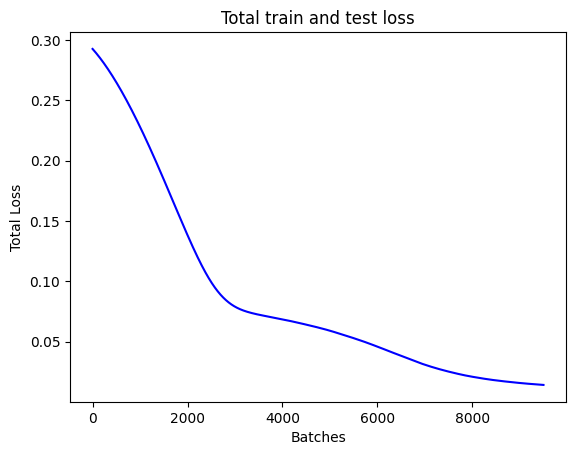

In [29]:
tot_epochs = 10000
checkpoint = 500
tot_used_data = int(X_train.shape[0]*used_data)
train_losses = []

print(X_train, y_train)
for epoch in tqdm(range(tot_epochs)):
    X_tr = X_train.to(device)
    #X_tr_encoded = autoencoder(X_tr, decoding=False)
    y_tr = y_train.to(device)

    # zero grad
    optim.zero_grad()

    # Apply Autoencoder
    predictions = regressor_LUMO(X_tr) - regressor_HOMO(X_tr)

    # Calculating the loss
    l2_lambda = 1e-5
    l2_norm = sum(param.pow(2.0).sum() for param in regressor_HOMO.parameters())
    train_loss = criterion(predictions, y_tr.unsqueeze(1)) + l2_lambda * l2_norm

    # backward pass and gradient step
    train_loss.backward()
    optim.step()

    # Save losses
    if epoch >= checkpoint:
        train_losses.append(train_loss.item())

    # Print losses
    if (epoch+1) % checkpoint == 0:
        print(f'Total train loss: {train_loss:.4f}')

# Plot the losses
plt.plot(np.asarray(train_losses), 'b')
plt.title('Total train and test loss')
plt.xlabel('Batches')
plt.ylabel('Total Loss')
plt.show()

#### RFR on last layer

### Make the predictions

In [30]:
# Predictions
with torch.no_grad():
    solution = sample

    X_L = regressor_LUMO(X_test.to(device)).squeeze(1)
    X_H = regressor_HOMO(X_test.to(device)).squeeze(1)

    predictions = X_L - X_H

    solution.iloc[:,1] = predictions[:].to('cpu')

    solution.to_csv(PATH+'/Solution.csv')

AttributeError: 'torch.dtype' object has no attribute 'kind'